In [170]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [219]:
# find the min and max values for each column
def dataset_minmax(dataset):
  minmax = list()
  for i in range(len(dataset[0])-1):
    col_values = [row[i] for row in dataset]
    value_min = min(col_values)
    value_max = max(col_values)
    minmax.append([value_min, value_max])
  return minmax

# rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
  for row in dataset:
    for i in range(len(row)-1):
      try:
        row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
      except ZeroDivisionError:
        row[i] = row[i] - minmax[i][0]


# calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
  distance = 0.0
  for i in range(len(row1)-1):
    distance += (row1[i] - row2[i])**2
  return np.sqrt(distance)


# locate the most similar neighbors
def get_neighbors(train, test_row, num_neighbors):
  distances = list()
  for train_row in train:
    dist = euclidean_distance(test_row, train_row)
    distances.append((train_row, dist))
  distances.sort(key=lambda tup: tup[1])
  neighbors = list()
  for i in range(num_neighbors):
    neighbors.append(distances[i][0])
  return neighbors


# make a prediction with neighbors
def predict_classification(train, test_row, num_neighbors):
  neighbors = get_neighbors(train, test_row, num_neighbors)
  output_values = [row[-1] for row in neighbors]
  prediction = max(set(output_values), key=output_values.count)
  return prediction

In [220]:
# extract numerical data, implementing one-hot encoding for track genre
names = ['doggo', 'not edgy', 'i feel like', 'untitled', 'whatever simulation', 'never forget', 'b', '떡볶이']
tracks_all = pd.DataFrame()
artists = pd.read_csv('artists.csv', index_col=0)
atg = pd.read_csv('all_top_genres.csv', index_col=0)
for name in names:
  df = pd.read_csv(name+'.csv', index_col=0)
  genres = []
  ohe = pd.DataFrame(columns=atg.all_top_genres.values)
  for artist in df.track_artists:
    try:
      genres = artists[artists['artist_name']==artist]['genres'].values[0]
      genres = genres.replace('[', '').replace(']', '').replace('\'', '').replace(', ', ',').split(',')
    except IndexError:
      genres = []
    a = {}
    for genre in atg.all_top_genres.values:
      if genre in genres:
        a[genre] = 1
      else:
        a[genre] = 0
    ohe = ohe.append(a, ignore_index=True)
  df = ohe.join(df)[atg.all_top_genres.values.tolist()+['energy', 'loudness', 'tempo', 'valence', 'danceability']]
  if name=='떡볶이':
    df['playlist'] = 'tteokbokki'
  else:
    df['playlist'] = name
  tracks_all = tracks_all.append(df, ignore_index=True)

# drop last track if total number of tracks not even
if len(tracks_all)%2 != 0:
  tracks_all = tracks_all.drop([len(tracks_all)-1])

tracks_all

,k-pop,k-pop girl group,korean ost,k-pop boy group,anime,pop,boy band,hip hop,rap,dance pop,soft rock,mellow gold,new wave pop,rock,classic rock,korean r&b,k-rap,r&b,pop rock,alternative rock,permanent wave,pop punk,modern rock,emo,progressive post-hardcore,skate punk,punk,alternative metal,socal pop punk,indie rock,energy,loudness,tempo,valence,danceability,playlist
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.933,-3.476,170.130,0.708,0.501,doggo
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.934,-3.347,169.907,0.591,0.513,doggo
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.946,-4.134,145.004,0.621,0.600,doggo
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.913,-3.493,156.076,0.409,0.538,doggo
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.970,-2.512,170.190,0.431,0.425,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.732,-4.865,82.026,0.436,0.665,tteokbokki
920,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.907,-2.487,120.069,0.778,0.739,tteokbokki
921,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.875,-2.739,88.938,0.708,0.656,tteokbokki
922,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.799,-2.849,103.991,0.782,0.659,tteokbokki


In [221]:
# sample 50% observations as training data
train = random.sample(range(0, len(tracks_all)), len(tracks_all)//2)
ttrain = tracks_all.index.isin(train)

tracks_train = tracks_all[ttrain]

# rest 50% as test data
tracks_test = tracks_all[~ttrain]

In [222]:
# create response vectors and design matrices for training and test set
YTrain = tracks_train['playlist'].tolist()
XTrain = tracks_train.drop('playlist', axis=1).values.tolist()

YTest = tracks_test['playlist'].tolist()
XTest = tracks_test.drop('playlist', axis=1).values.tolist()

tracks_train_values = tracks_train.values.tolist()

In [223]:
# normalize datasets
normalize_dataset(tracks_train_values, dataset_minmax(tracks_train_values))
normalize_dataset(XTrain, dataset_minmax(XTrain))
normalize_dataset(XTest, dataset_minmax(XTest))

In [225]:
# perform k-fold cross validation to select best number of neighbors
def do_chunk(k, folds, X_data, Y_data, num_neighbors):
  error_folds = pd.DataFrame(columns=['fold', 'train_error', 'val_error', 'neighbors'])  
  for chunkid in range(k):
    t = [fold!=chunkid for fold in folds]
    trn_indices = [i for i, x in enumerate(t) if x]
    val_indices = [i for i, x in enumerate(t) if not x]
    Xtr = [X_data[i] for i in trn_indices]
    Xvl = [X_data[i] for i in val_indices]
    Ytr = [Y_data[i] for i in trn_indices]
    Yvl = [Y_data[i] for i in val_indices]
    pred_labels_tr = []
    pred_labels_vl = []
    for row in Xtr:
      pred_labels_tr.append(predict_classification(Xtr, row, num_neighbors))
    for row in Xvl: 
      pred_labels_vl.append(predict_classification(Xtr, row, num_neighbors))
    matrix_tr = confusion_matrix(Ytr, pred_labels_tr, labels=names)
    matrix_vl = confusion_matrix(Yvl, pred_labels_vl, labels=names)

    trn_err = 1 - np.trace(matrix_tr)/np.sum(matrix_tr)
    val_err = 1 - np.trace(matrix_vl)/np.sum(matrix_vl)

    error_folds = error_folds.append({'fold':chunkid, 'train_error':trn_err,
                                      'val_error':val_err, 'neighbors':num_neighbors}, ignore_index=True)
    error_folds['fold'] = error_folds['fold'].astype(int)
    error_folds['neighbors'] = error_folds['neighbors'].astype(int)
  
  return error_folds

k = 3
folds = random.sample(list(pd.cut(range(0, len(XTrain)), bins=k, labels=False)), len(XTrain))
all_neighbors = 50

all_error_folds = pd.DataFrame(columns=['fold', 'train_error', 'val_error', 'neighbors'])
for num_neighbor in range(1, all_neighbors+1):
  all_error_folds = all_error_folds.append(do_chunk(k=k, folds=folds,
                                                    X_data=tracks_train_values, Y_data=YTrain,
                                                    num_neighbors=num_neighbor), ignore_index=True)
all_error_folds

,fold,train_error,val_error,neighbors
0,0,0.003937,0.333333,1
1,1,0.003846,0.363636,1
2,2,0.000000,0.338843,1
3,0,0.203187,0.340741,2
4,1,0.197674,0.356589,2
...,...,...,...,...
145,1,0.536965,0.503759,49
146,2,0.537037,0.533333,49
147,0,0.513834,0.554745,50
148,1,0.536965,0.503759,50


In [226]:
best_neighbors = all_error_folds.groupby(by='neighbors').mean()['val_error'].idxmin()
best_neighbors

7

In [227]:
# predictions on training set
pred_labels = []
for row in XTrain:
  pred_labels.append(predict_classification(tracks_train_values, row, best_neighbors))
len(pred_labels)

matrix = confusion_matrix(YTrain, pred_labels, labels=names)
print(matrix)
np.trace(matrix)/np.sum(matrix)

[[ 35   4   4   1   3   1   0   0]
 [  3 159   2   1   7   2   0   0]
 [  7  17  22   3   1   3   0   0]
 [  5   1   0  13   0   9   0   0]
 [  3  10   0   0  16   1   0   0]
 [  0   3   1   0   5  30   0   0]
 [  0   0   0   0   1   0  15   0]
 [  0   0   0   0   0   0   0   0]]


0.7474226804123711

In [228]:
# predictions on test set
pred_labels = []
for row in XTest:
  pred_labels.append(predict_classification(tracks_train_values, row, best_neighbors))
len(pred_labels)

matrix = confusion_matrix(YTest, pred_labels, labels=names)
print(matrix)
np.trace(matrix)/np.sum(matrix)

[[ 33   3   6   4   1   1   0   0]
 [  7 133   0   2   8   1   0   0]
 [  8  24  25   1   2   1   0   0]
 [  5   4   1   5   1   8   0   0]
 [  1   9   1   0  22   0   0   0]
 [  2   4   0   1   3  26   0   0]
 [  0   0   0   0   0   0  18   0]
 [  0   0   0   0   0   0   0   0]]


0.706199460916442

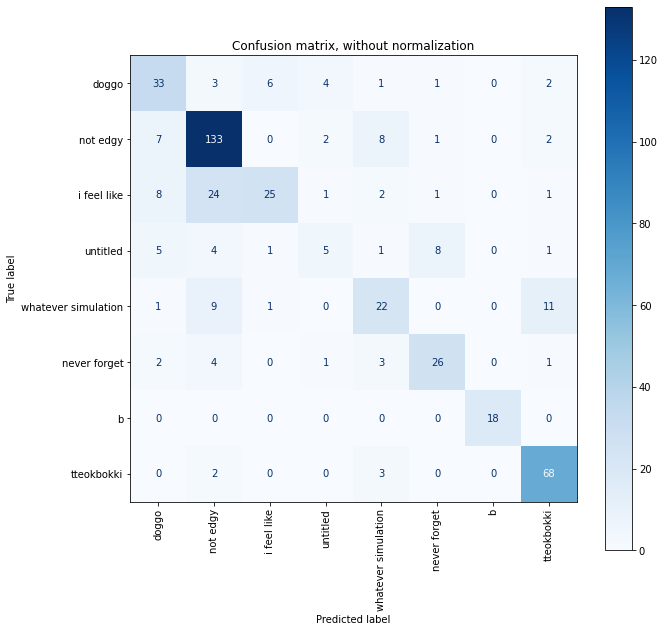

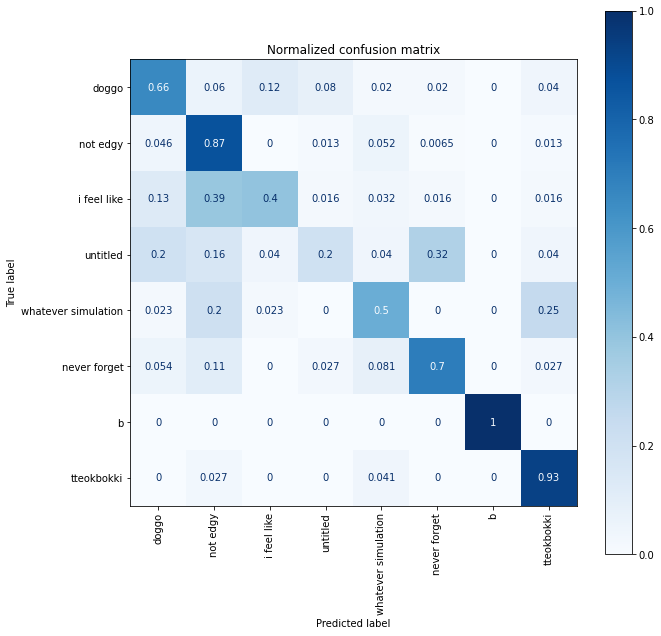

In [230]:
# visualize confusion matrix
names[-1] = 'tteokbokki'
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
  fig, ax = plt.subplots(figsize=(10,10))
  disp = ConfusionMatrixDisplay.from_predictions(
      YTest,
      pred_labels,
      labels=names,
      xticks_rotation='vertical',
      normalize=normalize,
      cmap=plt.cm.Blues,
      ax=ax)
  disp.ax_.set_title(title)
plt.show()